<a href="https://colab.research.google.com/github/spetznick/applied-gpu-programming/blob/colab-t/assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 2
Explain how the program is compiled and run.
For a vector length of N:

1. How many floating operations are being performed in your vector add kernel?
2. How many global memory reads are being performed by your kernel?

For a vector length of 512:

1. Explain how many CUDA threads and thread blocks you used.
2. Profile your program with Nvidia Nsight. What Achieved Occupancy did you get? You might find https://docs.nvidia.com/nsight-compute/NsightComputeCli/index.html#nvprof-metric-comparison
Links to an external site. useful.

Now increase the vector length to 262140:

1. Did your program still work? If not, what changes did you make?
2. Explain how many CUDA threads and thread blocks you used.
Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?

Further increase the vector length (try 6-10 different vector length), plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions.





In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Nov 24 15:04:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              12W /  7


## First exercise of the second assignment


In [2]:
%%writefile hw2_ex1.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len) {
  int myID = blockIdx.x * blockDim.x + threadIdx.x;
  if (myID < len) {
    out[myID] = in1[myID] + in2[myID];
  }
}

// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {
  if (argc < 4) {
    printf("Please provide vector length, thread number, and number of runs as command-line arguments.\n");
    return 1;
  }

  int inputLength = strtol(argv[1], NULL, 10);
  int numThreadsPerBlock = strtol(argv[2], NULL, 10);
  int numRuns = strtol(argv[3], NULL, 10);

  int size = inputLength * sizeof(DataType);
  DataType *hostInput1 = (DataType *)malloc(size);
  DataType *hostInput2 = (DataType *)malloc(size);
  DataType *hostOutput = (DataType *)malloc(size);
  DataType *resultRef = (DataType *)malloc(size);

  // Initialize host inputs with random values
  srand(time(NULL));
  for (int i = 0; i < inputLength; ++i) {
    hostInput1[i] = (DataType)rand() / RAND_MAX;
    hostInput2[i] = (DataType)rand() / RAND_MAX;
  }

  DataType *deviceInput1, *deviceInput2, *deviceOutput;
  cudaMalloc(&deviceInput1, size);
  cudaMalloc(&deviceInput2, size);
  cudaMalloc(&deviceOutput, size);

  dim3 blockDim(numThreadsPerBlock);
  dim3 gridDim((inputLength + blockDim.x - 1) / blockDim.x);
  printf("The input length is %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceInput1, hostInput1, size, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceInput2, hostInput2, size, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    // Time kernel execution
    cudaEventRecord(start);
    vecAdd<<<gridDim, blockDim>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    // Time data copy back to host
    cudaEventRecord(start);
    cudaMemcpy(hostOutput, deviceOutput, size, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Input length %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);
  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  // Error checking and final result comparison
  for (int i = 0; i < inputLength; ++i) {
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }
  for (int i = 0; i < inputLength; ++i) {
    if (abs(resultRef[i] - hostOutput[i]) > 1e-5) {
      printf("Addition wrong at %i: (cpu, gpu) = (%.3f, %.3f)\n", i, resultRef[i], hostOutput[i]);
      break;
    }
  }

  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Writing hw2_ex1.cu


## We compile the saved cuda code using nvcc compiler

In [3]:
!nvcc hw2_ex1.cu -o hw2_ex1
!ls


hw2_ex1  hw2_ex1.cu  sample_data


## Finally, we execute the binary of the compiled code

In [4]:
!./hw2_ex1 10 256 10
!./hw2_ex1 10 512 10
!./hw2_ex1 512 256 10
!./hw2_ex1 512 512 10
!./hw2_ex1 512 1024 10
!./hw2_ex1 10000 256 10
!./hw2_ex1 10000 512 10
!./hw2_ex1 10000 1024 10
!./hw2_ex1 100000 256 10
!./hw2_ex1 100000 512 10
!./hw2_ex1 100000 1024 10

The input length is 10, (numBlocks, numThreadsPerBlock) = (1, 256).
Input length 10, (numBlocks, numThreadsPerBlock) = (1, 256).
Average kernel execution time of 10 runs: 9.6669 +- 28.9798 ms
Average time for data copy to device:     0.1117 +- 0.2801 ms
Average time for data copy to host:       0.0133 +- 0.0040 ms
The input length is 10, (numBlocks, numThreadsPerBlock) = (1, 512).
Input length 10, (numBlocks, numThreadsPerBlock) = (1, 512).
Average kernel execution time of 10 runs: 0.0226 +- 0.0491 ms
Average time for data copy to device:     0.0166 +- 0.0027 ms
Average time for data copy to host:       0.0155 +- 0.0060 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 10 runs: 0.0243 +- 0.0520 ms
Average time for data copy to device:     0.0217 +- 0.0065 ms
Average time for data copy to host:       0.0146 +- 0.0033 ms
The input length is 512, (numBlocks, numThreadsPerBl

## Vector length 512

In [12]:
!ncu --section "Occupancy" ./hw2_ex1 512 512 1

==PROF== Connected to process 10007 (/content/hw2_ex1)
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 512).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Average kernel execution time of 1 runs: 229.7838 +- 0.0000 ms
Average time for data copy to device:     0.0413 +- 0.0000 ms
Average time for data copy to host:       0.0342 +- 0.0000 ms
==PROF== Disconnected from process 10007
[10007] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (1, 1, 1)x(512, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block            8
    Block Limit Shared Mem                block           16
    Bl

## Vector length 262140

In [18]:
!ncu --section "Occupancy" ./hw2_ex1 262140 512 1

==PROF== Connected to process 11500 (/content/hw2_ex1)
The input length is 262140, (numBlocks, numThreadsPerBlock) = (512, 512).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Input length 262140, (numBlocks, numThreadsPerBlock) = (512, 512).
Average kernel execution time of 1 runs: 231.2829 +- 0.0000 ms
Average time for data copy to device:     1.3434 +- 0.0000 ms
Average time for data copy to host:       1.8971 +- 0.0000 ms
==PROF== Disconnected from process 11500
[11500] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (512, 1, 1)x(512, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block            8
    Block Limit Shared Mem                block        

## Experiment with other sizes

In [29]:
!./hw2_ex1 100000 256 10
!./hw2_ex1 500000 256 10
!./hw2_ex1 1000000 256 10
!./hw2_ex1 5000000 256 10
!./hw2_ex1 10000000 256 10
!./hw2_ex1 50000000 256 10

The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0305 +- 0.0500 ms
Average time for data copy to device:     0.4603 +- 0.0266 ms
Average time for data copy to host:       0.3066 +- 0.1274 ms
The input length is 500000, (numBlocks, numThreadsPerBlock) = (1954, 256).
Input length 500000, (numBlocks, numThreadsPerBlock) = (1954, 256).
Average kernel execution time of 10 runs: 0.0644 +- 0.0459 ms
Average time for data copy to device:     1.7830 +- 0.1260 ms
Average time for data copy to host:       1.1775 +- 0.6521 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1146 +- 0.0496 ms
Average time for data copy to device:     3.4769 +- 0.2609 ms
Average time for data copy to host:       2.2141 +- 1.1507 ms
The input len

   Input Length  Kernel Execution Time (ms)  Copy to Device Time (ms)  \
0        100000                      0.0305                    0.4603   
1        500000                      0.0644                    1.7830   
2       1000000                      0.1146                    3.4769   
3       5000000                      0.4834                   16.8406   
4      10000000                      0.9443                   33.6987   
5      50000000                      4.5824                  166.8384   

   Copy to Host Time (ms)  
0                  0.3066  
1                  1.1775  
2                  2.2141  
3                 10.4858  
4                 21.4966  
5                104.1809  


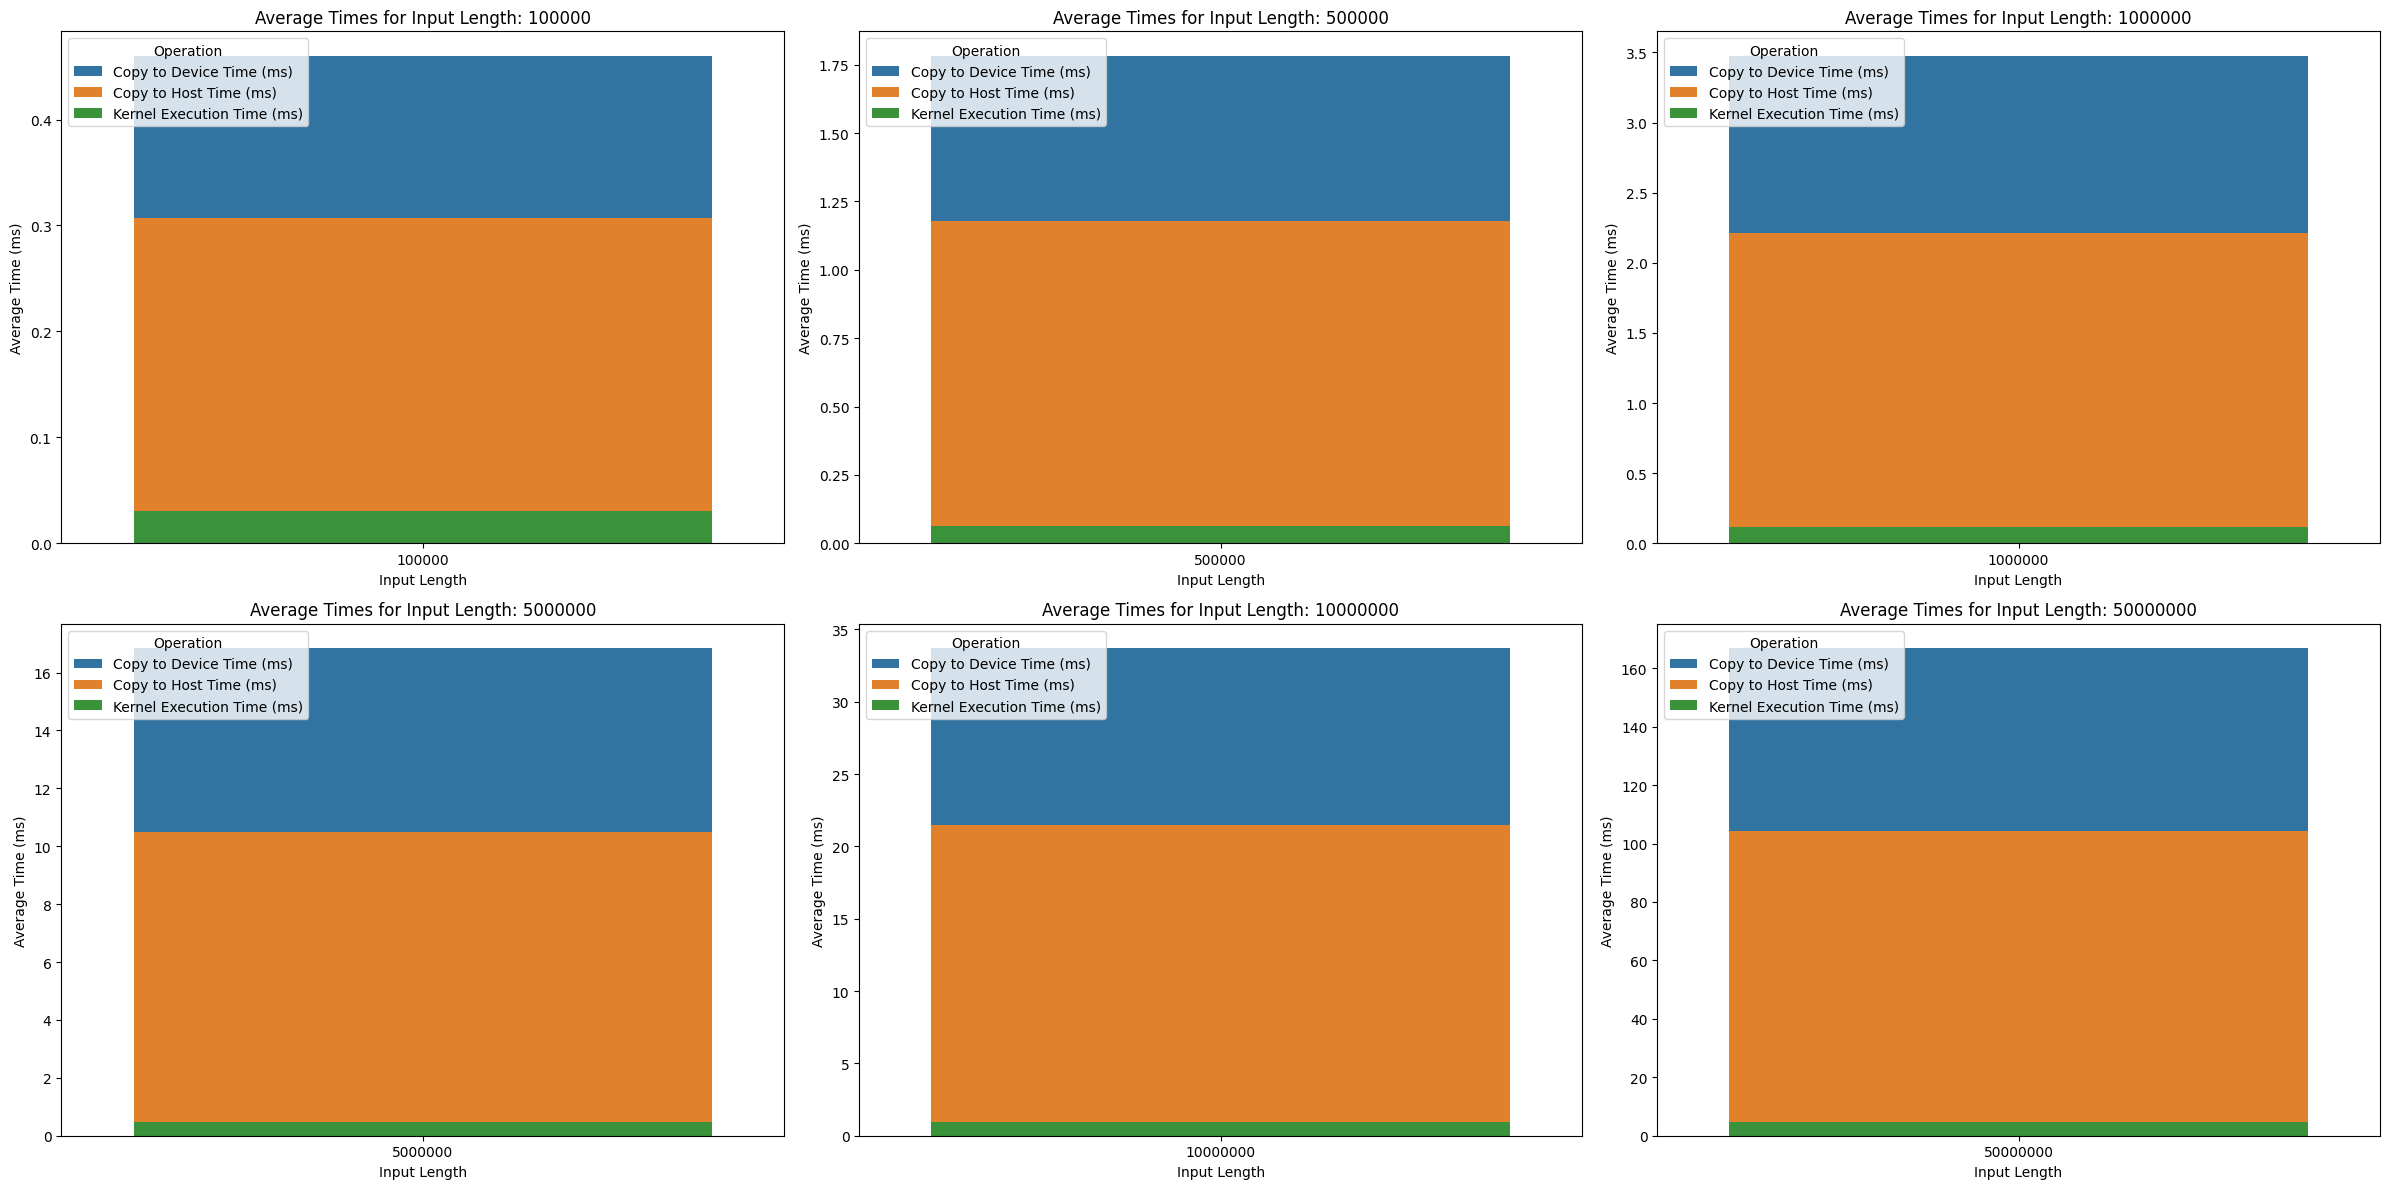

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import pandas as pd

def parse_results(results_str):
    """
    Parses the results of multiple test runs and returns a DataFrame.

    Args:
    - results_str (str): A string containing the test run output.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the parsed results.
    """

    # Regex pattern to match each block of results for a single input length
    pattern = r"The input length is (\d+), \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Input length \d+, \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to device: +([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to host: +([\d.]+) \+- [\d.]+ ms"

    # Use regex to find all matches in the string
    matches = re.findall(pattern, results_str)

    # Create a list to store the parsed data
    data = []

    # Parse each match and store as a dictionary
    for match in matches:
        input_length = int(match[0])
        kernel_time = float(match[1])
        copy_to_device_time = float(match[2])
        copy_to_host_time = float(match[3])

        # Append the parsed data to the list
        data.append({
            "Input Length": input_length,
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage with the input printout string
results_str = """
The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0305 +- 0.0500 ms
Average time for data copy to device:     0.4603 +- 0.0266 ms
Average time for data copy to host:       0.3066 +- 0.1274 ms
The input length is 500000, (numBlocks, numThreadsPerBlock) = (1954, 256).
Input length 500000, (numBlocks, numThreadsPerBlock) = (1954, 256).
Average kernel execution time of 10 runs: 0.0644 +- 0.0459 ms
Average time for data copy to device:     1.7830 +- 0.1260 ms
Average time for data copy to host:       1.1775 +- 0.6521 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1146 +- 0.0496 ms
Average time for data copy to device:     3.4769 +- 0.2609 ms
Average time for data copy to host:       2.2141 +- 1.1507 ms
The input length is 5000000, (numBlocks, numThreadsPerBlock) = (19532, 256).
Input length 5000000, (numBlocks, numThreadsPerBlock) = (19532, 256).
Average kernel execution time of 10 runs: 0.4834 +- 0.0628 ms
Average time for data copy to device:     16.8406 +- 0.3532 ms
Average time for data copy to host:       10.4858 +- 6.1517 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9443 +- 0.0535 ms
Average time for data copy to device:     33.6987 +- 0.4136 ms
Average time for data copy to host:       21.4966 +- 13.3889 ms
The input length is 50000000, (numBlocks, numThreadsPerBlock) = (195313, 256).
Input length 50000000, (numBlocks, numThreadsPerBlock) = (195313, 256).
Average kernel execution time of 10 runs: 4.5824 +- 0.0600 ms
Average time for data copy to device:     166.8384 +- 1.8256 ms
Average time for data copy to host:       104.1809 +- 59.0644 ms
"""

# Parse the results
df = parse_results(results_str)

# Print the resulting DataFrame
print(df)

# # Data preparation
# data = {
#     "Input Length": [100000, 1000000, 5000000, 10000000, 50000000, 100000000],
#     "Kernel Execution Time (ms)": [0.0332, 0.1134, 0.4788, 0.9397, 4.5879, 9.1720],
#     "Copy to Device Time (ms)": [0.4653, 3.2890, 16.9438, 34.2606, 171.6111, 335.4579],
#     "Copy to Host Time (ms)": [0.3076, 2.1924, 10.8117, 21.0833, 104.4536, 207.1870]
# }

# # Convert the data into a pandas DataFrame
# df = pd.DataFrame(data)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(id_vars="Input Length",
                    value_vars=["Copy to Device Time (ms)", "Copy to Host Time (ms)", "Kernel Execution Time (ms)"],
                    var_name="Operation",
                    value_name="Time (ms)")

# Plotting the stacked bar plot
# plt.figure(figsize=(12, 6))
# sns.barplot(data=df_melted, x="Input Length", y="Time (ms)", hue="Operation", dodge=False)

# # Adding plot details
# plt.title("Average Times for Data Copy and Kernel Execution")
# plt.xlabel("Input Length")
# plt.ylabel("Average Time (ms)")
# plt.yscale("log")  # Log scale can help better visualize the differences across large ranges
# plt.legend(title="Operation", loc="upper left")

# plt.show()

# Create a list of unique "Input Length" values
unique_input_lengths = df_melted["Input Length"].unique()

# Determine the number of subplots based on unique input lengths
num_subplots = len(unique_input_lengths)

# Set up the figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

axes = axes.flatten()

# Iterate over each unique input length and create a subplot
for i, input_length in enumerate(unique_input_lengths):
    ax = axes[i] if num_subplots > 1 else axes  # Handle case where there's only one subplot
    sns.barplot(
        data=df_melted[df_melted["Input Length"] == input_length],
        x="Input Length",
        y="Time (ms)",
        hue="Operation",
        dodge=False,
        ax=ax
    )

    # Add subplot details
    ax.set_title(f"Average Times for Input Length: {input_length}")
    ax.set_xlabel("Input Length")
    ax.set_ylabel("Average Time (ms)")
    # ax.set_yscale("log")  # Log scale
    ax.legend(title="Operation", loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

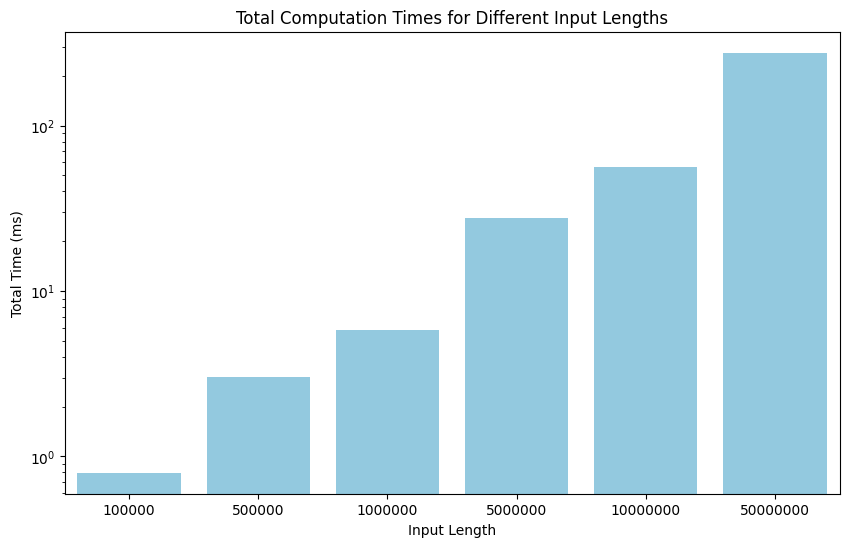

In [35]:
df_total = df_melted.groupby("Input Length")["Time (ms)"].sum().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_total, x="Input Length", y="Time (ms)", color="skyblue")

# Adding plot details
plt.title("Total Computation Times for Different Input Lengths")
plt.xlabel("Input Length")
plt.ylabel("Total Time (ms)")
plt.yscale("log")  # Log scale for better visualization of large differences

plt.show()

In [36]:
%%writefile hw2_ex2.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

// Compute C = A * B each thread computes a single entry
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  DataType cValue = 0;
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  if (row < numARows && col < numBColumns) {
    for (int i = 0; i < numAColumns; ++i) {
      cValue += A[row * numAColumns + i] * B[i * numBColumns + col];
    }
    C[row * numBColumns + col] = cValue;
  }
}

void printMatrix(const double *matrix, int numRows, int numCols) {
    for (int i = 0; i < numRows; ++i) {
        for (int j = 0; j < numCols; ++j) {
            printf("%8.4f ", matrix[i * numCols + j]);
        }
        printf("\n");
    }
    printf("\n");
}


// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {

  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;
  int numRuns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  if (argc < 6) {
    printf("Please provide number of matrix rows and columns of A and B, respectively, and the number of runs as command-line arguments.\n");
    return 1;
  }

  numARows = strtol(argv[1], NULL, 10);
  numAColumns = strtol(argv[2], NULL, 10);
  numBRows = strtol(argv[3], NULL, 10);
  numBColumns = strtol(argv[4], NULL, 10);
  numRuns = strtol(argv[5], NULL, 10);
  numCRows = numARows;
  numCColumns = numBColumns;

  //! Input dim is given as expected by user but internally, B matrix is stored in column-major
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);


  //@@ Insert code below to allocate Host memory for input and output
  int sizeA = numAColumns * numARows * sizeof(DataType);
  int sizeB = numBColumns * numBRows * sizeof(DataType);
  int sizeC = numCColumns * numCRows * sizeof(DataType);
  hostA = (DataType *)malloc(sizeA);
  hostB = (DataType *)malloc(sizeB);
  hostC = (DataType *)malloc(sizeC);
  resultRef = (DataType *)malloc(sizeC);


  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  srand(time(NULL));
  for (int i = 0; i < numARows * numAColumns; ++i) {
      hostA[i] = (DataType)rand() / RAND_MAX;
  }
  for (int i = 0; i < numBRows * numBColumns; ++i) {
      hostB[i] = (DataType)rand() / RAND_MAX;
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceA, sizeA);
  cudaMalloc(&deviceB, sizeB);
  cudaMalloc(&deviceC, sizeC);

  //@@ Initialize the grid and block dimensions here
  // 16x16 should be possible for most architectures
  dim3 blockDim(16, 16);
  dim3 gridDim((numBColumns + blockDim.x - 1) / blockDim.x,
              (numARows + blockDim.y - 1) / blockDim.y);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    //@@ Insert code to below to Copy memory to the GPU here
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceA, hostA, sizeA, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, hostB, sizeB, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    //@@ Launch the GPU Kernel here
    cudaEventRecord(start);
    gemm<<<gridDim, blockDim>>>(deviceA, deviceB, deviceC, numARows,
                      numAColumns, numBRows, numBColumns);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    //@@ Copy the GPU memory back to the CPU here
    cudaEventRecord(start);
    cudaMemcpy(hostC, deviceC, sizeC, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  //@@ Insert code below to compare the output with the reference
  for (int row = 0; row < numARows; ++row) {
      for (int col = 0; col < numBColumns; ++col) {
          resultRef[row * numBColumns + col] = 0.0;
          for (int k = 0; k < numAColumns; ++k) {
              resultRef[row * numBColumns + col] += hostA[row * numAColumns + k] * hostB[k * numBColumns + col];
          }
      }
  }

  DataType eps = 1e-5;
  for (int i = 0; i < numCRows * numCColumns; ++i) {
    if (fabs(hostC[i] - resultRef[i]) > eps) {
        printf("Result wrong at index %d\n", i);
    }
  }

  //@@ Free the GPU memory here
  cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);
  //@@ Free the CPU memory here
  free(hostA);
  free(hostB);
  free(hostC);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  // Free timer memory
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Writing hw2_ex2.cu


In [37]:
!nvcc hw2_ex2.cu -o hw2_ex2
!ls

hw2_ex1  hw2_ex1.cu  hw2_ex2  hw2_ex2.cu  sample_data


In [ ]:
!ncu --section "Occupancy" ./hw2_ex2 64 128 128 64 1

In [ ]:
!./hw2_ex2 1024 1023 1023 8193 1

Input matrix dim (3409 x 3408) (3408 x 27363) (3409 x 27363)
Average kernel execution time of 1 runs: 3839.7095 +- 0.0000 ms
Average time for data copy to device:     180.3478 +- 0.0000 ms
Average time for data copy to host:       577.5593 +- 0.0000 ms


In [ ]:
!ncu --section "Occupancy" ./hw2_ex2 1024 1023 1023 8193 1


1. Name three applications domains of matrix multiplication.
2. How many floating operations are being performed in your matrix multiply kernel?
3. How many global memory reads are being performed by your kernel?  
4. For a matrix A of (64x128) and B of (128x64):
  - Explain how many CUDA threads and thread blocks you used.
  - Profile your program with Nvidia Nsight. What Achieved Occupancy did you get?
5. For a matrix A of (1024x1023) and B of (1023x8193):
  - Did your program still work? If not, what changes did you make?
  - Explain how many CUDA threads and thread blocks you used.
  - Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?
6. Further increase the size of matrix A and B, plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions. Explain what you observe.
7. Now, change DataType from double to float, re-plot the a stacked bar chart showing the time breakdown. Explain what you observe.
